# 1. Imports

In [7]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("data_final.csv")
df.head()

,PERMNO,date,SICCD,RET,vwretd,SICCD_peers,RET_peers,date_rel,RET_neigh,Mkt_RF,SMB,HML,RMW,CMA,RF
0,10032,20170227,3670.0,-0.003292,0.001999,3670.0,0.007154,-250,-0.002337,0.0022,0.0085,-0.0033,-0.0038,-0.0015,0.00002
1,10032,20170228,3670.0,-0.025209,-0.004651,3670.0,-0.022114,-249,-0.008818,-0.0042,-0.0136,0.0016,-0.0001,-0.0020,0.00002
2,10032,20170301,3670.0,0.022650,0.013383,3670.0,0.021281,-248,0.024245,0.0147,0.0052,0.0077,-0.0054,0.0054,0.00001
3,10032,20170302,3670.0,-0.007848,-0.006866,3670.0,-0.008909,-247,-0.009514,-0.0070,-0.0054,-0.0090,0.0063,-0.0043,0.00001
4,10032,20170303,3670.0,-0.005273,0.000944,3670.0,-0.001480,-246,-0.000025,0.0009,-0.0018,0.0014,-0.0006,-0.0010,0.00001


# 2. Features correlation matrix

In [4]:
corr_mat = df.corr()

<Axes: >

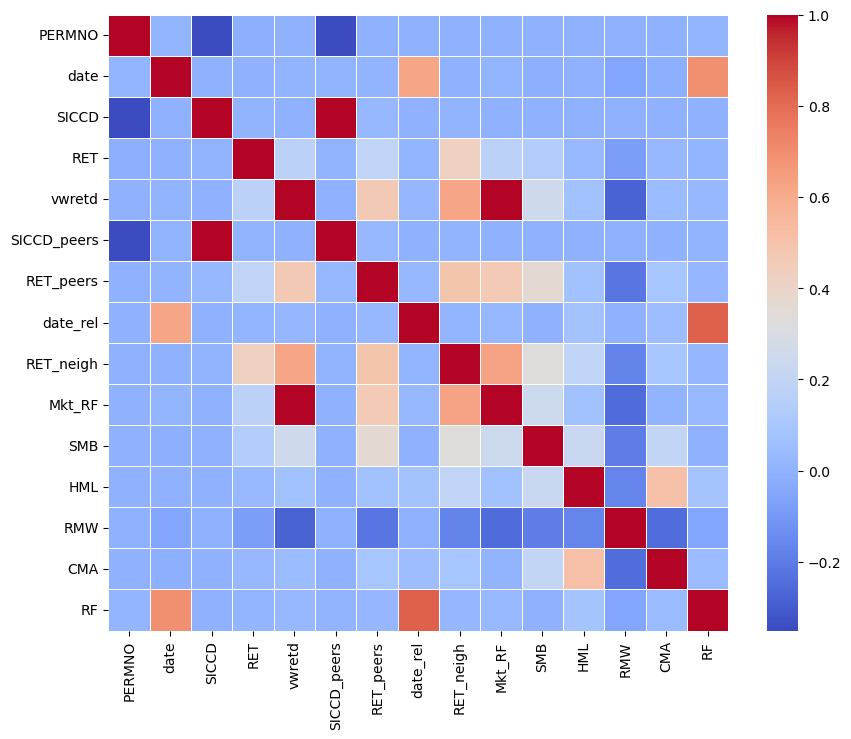

In [5]:
plt.rcParams["figure.figsize"] = (10, 8)
corr_mat = df.corr()
sns.heatmap(corr_mat, annot=False, cmap='coolwarm', linewidths=.5)

# 3. Standard linear models

## 3.1. Features and model names

In [8]:
features = [['vwretd'], ['vwretd', 'RET_peers'], ['vwretd','RET_neigh'],
           ['vwretd', 'SMB','HML'],
           ['vwretd','SMB','HML','RMW','CMA']
           ]

names_linear = ['MM', 'MMP', 'MMN', 'MMFF3', 'MMFF5']

## 3.2. Model training

In [23]:
PERMNO_list = pd.unique(df['PERMNO'])

output = np.empty((len(df), len(names_linear))) # for storage of ARs

from sklearn.linear_model import LinearRegression

LinearModel = LinearRegression(fit_intercept=True)

for feat_index, feat in enumerate(features):# iterate over features sets
    
    ARs_linear = list() # for storage of current model's AR over all stocks
    
    for PERMNO in PERMNO_list:# iterate over all stocks
        
        # cur_PERMNO = # current stock's PERMNO
        cur_PERMNO_data = df[df['PERMNO'] == PERMNO] # select current stock's data
        X, y = cur_PERMNO_data[feat].to_numpy().reshape(-1, len(feat)), cur_PERMNO_data['RET'].to_numpy().reshape(-1, 1) # current features, # current labels. y must be a column vector => reshape X and y accordingly
        X_train, y_train = X[:-1, :],y[:-1, :] # train features, # train labels

        estimModel = LinearModel.fit(X_train, y_train)
        stock_ARs = (y - estimModel.predict(X)).reshape(-1).tolist()# compute abnormal returns for current stock on all dates (estimation window + event date)

        ARs_linear.extend(stock_ARs)

    output[:, feat_index] = np.asarray(ARs_linear)# store ARs for current model in output array

ARs_linear = pd.DataFrame(output, columns=names_linear)# create pandas dataframe from ouput matrix. Column headers correspond to model names 
df = pd.concat([df, ARs_linear], axis = 1)# concatenate ARs_linear with dataframe df


## 3.2. Abnormal returns

In [24]:
AR_estim = df[df['date_rel']<0][names_linear]# ARs on estimation period for all linear models
AR_estim.head()

,MM,MMP,MMN,MMFF3,MMFF5
0,-0.005095,-0.005926,0.001816,-0.012461,-0.012583
1,-0.019871,-0.017072,-0.011642,-0.009196,-0.009344
2,0.008622,0.008042,-0.011777,0.007314,0.007475
3,-0.000131,-0.000249,0.006173,0.001683,0.001705
4,-0.005943,-0.005482,-0.004226,-0.004213,-0.004315


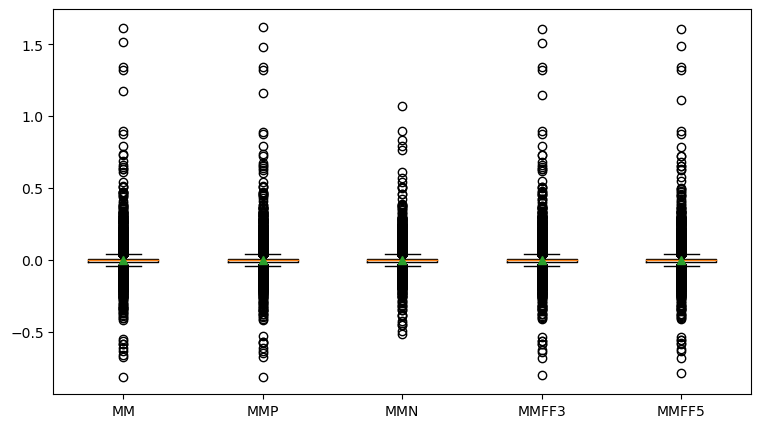

In [25]:
plt.rcParams["figure.figsize"] = (9, 5) 
plt.boxplot(AR_estim.values, labels = AR_estim.columns, showmeans=True)
plt.show()

In [26]:
AR_event = df[df['date_rel']==0][names_linear]# ARs on event date for all models

In [27]:
AR_event.head()

,MM,MMP,MMN,MMFF3,MMFF5
250,-0.007471,-0.009529,-0.003329,-0.002997,-0.002989
501,-0.006440,-0.005782,-0.009164,-0.002879,-0.002163
752,0.036636,0.032759,0.027070,0.030656,0.030036
1003,-0.012668,-0.008733,-0.018157,-0.008801,-0.008655
1254,-0.048857,-0.053680,-0.028802,-0.050036,-0.049874


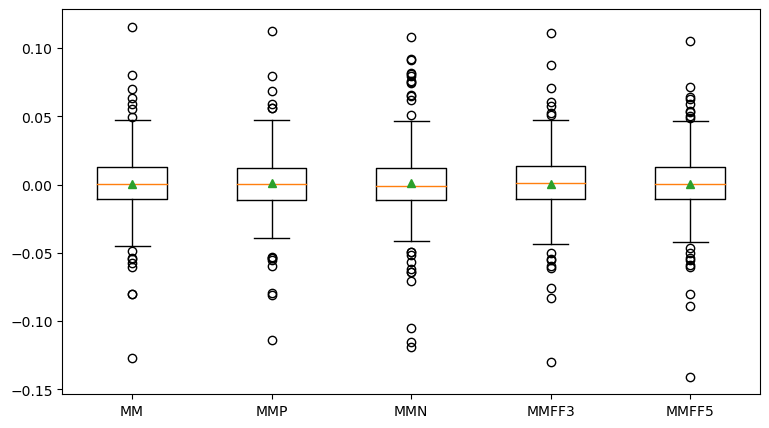

In [28]:
plt.rcParams["figure.figsize"] = (9, 5) 
plt.boxplot(AR_event.values, labels = AR_event.columns, showmeans=True)
plt.show()

# 4. Alternative models

## 4.1. Model definitions

In [ ]:
def get_models():
    models, names = list(), list()
    # Ridge
    models.append(RidgeCV())
    names.append('Ridge')
    
    # Lasso
    models.append(LassoCV())
    names.append('Lasso')
    
    # ElasticNet
    models.append(ElasticNetCV())
    names.append('ElasticNet')    
    
    # DT
    models.append(DecisionTreeRegressor(max_depth=5, min_samples_split=0.4))
    names.append('DT')
    
    # RF
    models.append(RandomForestRegressor(max_depth=5, min_samples_split=0.4))
    names.append('RandForest')
    
    return models, names

## 4.2. Model training

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


models, names = get_models()

output = np.empty((len(df), len(models))) # for storage of ARs

features = # list of features 
   
for model in range(len(models)):
    
    ARs_model = list()

    for stock in range(len(PERMNO_list)):

        cur_PERMNO = PERMNO_list[stock]
        cur_PERMNO_data = df[df['PERMNO']==cur_PERMNO]

        X, y  = # features, # labels
        X_train, y_train = # train features, # train labels 

        estimModel = # fit model
        ARs = # compute stock's ARs (estimation window + event date)

        ARs_model = ARs_model + ARs

    output[# store ARs for current model in output array

ARs_altModels = # create pandas dataframe from ouput matrix. Column headers correspond to model names 
df_all = # concatenate ARs_altModels with dataframe df

In [ ]:
df_all.head()

In [ ]:
model_names_all = names_linear + names

## 4.3. Abnormal returns (standard + alternative models)

In [ ]:
ARs_estim = # estimation window ARs for all  models (linear + alternative models)
plt.rcParams["figure.figsize"] = (9, 5) 
plt.boxplot(ARs_estim.values, labels=model_names_all, showmeans=True)
plt.show()

In [ ]:
AR0s = # event date ARs for all  models (linear + alternative models)

In [ ]:
plt.rcParams["figure.figsize"] = (9, 5) 
plt.boxplot(AR0s.values, labels=model_names_all, showmeans=True)
plt.show()

In [ ]:
ARs_estim = # ARs on estimation window for all models. Select column PERMNO + volumns of the ARs for all models (liner + alternative)
RMSEs_estim = # compute estimation window RMSE by PERMNO
RMSEs_estim.head()

In [ ]:
ARs_test = # ARs on event window for all models. Select columns PERMNO + those of the ARs of all models (liner + alternative)
ARs_test.head()

## 4.4. Model evaluation

- For each model a x% abnormal return is created by adding x% shock to the date 0 actual return.
- Shock values are: -0.1, -0.05, -0.02, -0.01, 0, 0.01, 0.02, 0.05, 0.1
- Shock value 0 aims at testing the specification of the various models (Type 1 error)
- Other shock values aim at testing the power of the various models (Type 2 error)

The null hypothesis $AR^{(m)}_{i,0}=0$ is rejected for stock $i$ and model $(m)$ if $\frac{AR^{(m)}_{i,0}}{RMSE_i^{(m)}}>z_{\alpha}$

In [ ]:
shocks = # list of shock values
from scipy.stats import norm
alpha = norm.ppf(0.975) # 5% level

In [ ]:
rejection_rates = # empty matrix:  number of rows = number of thresholds / number of columns = number of models

In [ ]:
for th in range(len(thresholds)):
    z_score = # compute z score
    T_spec = # count number of rejections
    freq_reject = # compute rejection frequency
    reject_rates[th,] = freq_reject

In [ ]:
res = pd.DataFrame(reject_rates, columns=model_names_all)
res.index = thresholds
res

## 4.5. Confidence interval for rejection rate

Wald confidence interval for a binomial proportion ($p$):
$$
p \pm z \times \sqrt{\frac{p(1-p)}{n}}
$$
where $z$ is the confidence level (1.96 for a 95% confidence interval).

In [ ]:
import math

# Sample data
number_rejections = int(5/100*256)+1 
total_trials = 256

# Sample proportion
p = number_rejections / total_trials

confidence_level = 0.95

# Z score based on confidence level
Z = norm.ppf((1 + confidence_level) / 2)

# Standard error
standard_error = math.sqrt((p * (1 - p)) / total_trials)

# Margin of error
margin_of_error = Z * standard_error

# Confidence interval
lower_limit = round((p - margin_of_error)*100,1)
upper_limit = round((p + margin_of_error)*100,1)

print(f"Sample Proportion: {p_hat}")
print(f"Confidence Interval: [{lower_limit}, {upper_limit}]")